#Abordagem Metodológica
A estrutura do trabalho está dividida nos seguintes blocos:

1. Importação e preparação de dados
As bases foram carregadas e integradas, com aplicação de análise de valores ausentes, verificação de consistência de tipos e preparação para análises posteriores.

2. Análise exploratória (EDA)
Foram exploradas as distribuições de variáveis, presença de outliers, correlações entre atributos e comparações entre grupos (clientes que compraram vs. não compraram). Ferramentas como missingno, seaborn e scipy.stats foram aplicadas nessa fase.

3. Modelagem preditiva: Classificação de clientes propensos à compra
Utilizando técnicas de aprendizado supervisionado (Random Forest e XGBoost Classifier), o estudo busca classificar clientes com maior probabilidade de efetuar uma compra de seguro com base em seus atributos históricos. O desempenho dos modelos foi avaliado com métricas robustas como AUC-ROC, acurácia e classification_report.

4. Interpretação de modelos e explicabilidade
Para garantir transparência e interpretabilidade, foi utilizada a biblioteca SHAP (SHapley Additive exPlanations), que permite quantificar a contribuição de cada variável para a previsão individual e geral, auxiliando na compreensão de fatores determinantes da conversão.

5. Análise de séries temporais
Foram utilizadas ferramentas como STL e ARIMA para explorar a componente temporal do comportamento de compra, identificando padrões sazonais, tendências e potenciais janelas comerciais mais propensas à conversão.

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import missingno as msno

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report

import shap

In [2]:
df_clientes = pd.read_csv("/content/drive/MyDrive/Consutorias/Brasil Seg/data_raw/clientes.csv")
df_vendas = pd.read_csv("/content/drive/MyDrive/Consutorias/Brasil Seg/data_raw/vendas_seguros.csv")

#Integração e Preparação da Base Unificada: Clientes + Vendas

Objetivo e Metodologia
1. Integração das Bases:
* As colunas de ambas as tabelas são listadas para conferência estrutural.
* Remove-se de df_vendas colunas não analíticas ou identificadoras diretas:
  * id_venda: chave sem valor preditivo.
  * origem_interacao: considerada irrelevante neste ponto da modelagem.
* A fusão (merge) é feita pela chave id_cliente no modo left, garantindo que todos os clientes sejam mantidos, mesmo que não tenham realizado uma venda.

2. Mapeamento de Categorias para Números:
Para permitir a aplicação de modelos de machine learning, variáveis categóricas foram transformadas em representações numéricas explícitas
Esse processo permite a codificação semântica dos dados, respeitando a ordem quando aplicável (ex: risco crescente, estado civil).

3. Conversão Temporal:
* A coluna data_venda é convertida para o tipo datetime, permitindo análises sazonais ou temporais futuras (ex: frequência de compra por período).

4. Análise de Tipos e Dados Ausentes:
* O método msno.matrix(df_merge) gera uma visualização gráfica da distribuição de valores ausentes por variável e instância.
* A verificação de tipos com df_numerico.dtypes garante consistência dos dados para as próximas etapas.

In [3]:
colunas_clientes = df_clientes.columns.tolist()
colunas_vendas = df_vendas.columns.tolist()

print(colunas_clientes)
print(colunas_vendas)

['id_cliente', 'idade', 'estado_civil', 'tempo_cliente_meses', 'possui_outros_produtos', 'perfil_risco']
['id_venda', 'id_cliente', 'tipo_produto', 'canal_venda', 'data_venda', 'valor_premio', 'status', 'origem_interacao']


In [4]:
remove_col_vendas = df_vendas.drop(columns = ["id_venda","origem_interacao" ])

print(f"Colunas selecionadas para composição na base clientes{df_clientes.columns.tolist()}.")
print(f"Colunas selecionadas para composição na base vendas{remove_col_vendas.columns.tolist()}.")

Colunas selecionadas para composição na base clientes['id_cliente', 'idade', 'estado_civil', 'tempo_cliente_meses', 'possui_outros_produtos', 'perfil_risco'].
Colunas selecionadas para composição na base vendas['id_cliente', 'tipo_produto', 'canal_venda', 'data_venda', 'valor_premio', 'status'].


In [5]:
df_merge = pd.merge(df_clientes, remove_col_vendas, on = "id_cliente", how = "left")
print(f"Colunas selecionadas{df_merge.columns.tolist()}")

Colunas selecionadas['id_cliente', 'idade', 'estado_civil', 'tempo_cliente_meses', 'possui_outros_produtos', 'perfil_risco', 'tipo_produto', 'canal_venda', 'data_venda', 'valor_premio', 'status']


In [6]:
df_merge.dtypes

,0
id_cliente,int64
idade,int64
estado_civil,object
tempo_cliente_meses,int64
possui_outros_produtos,object
perfil_risco,object
tipo_produto,object
canal_venda,object
data_venda,object
valor_premio,float64


<Axes: >

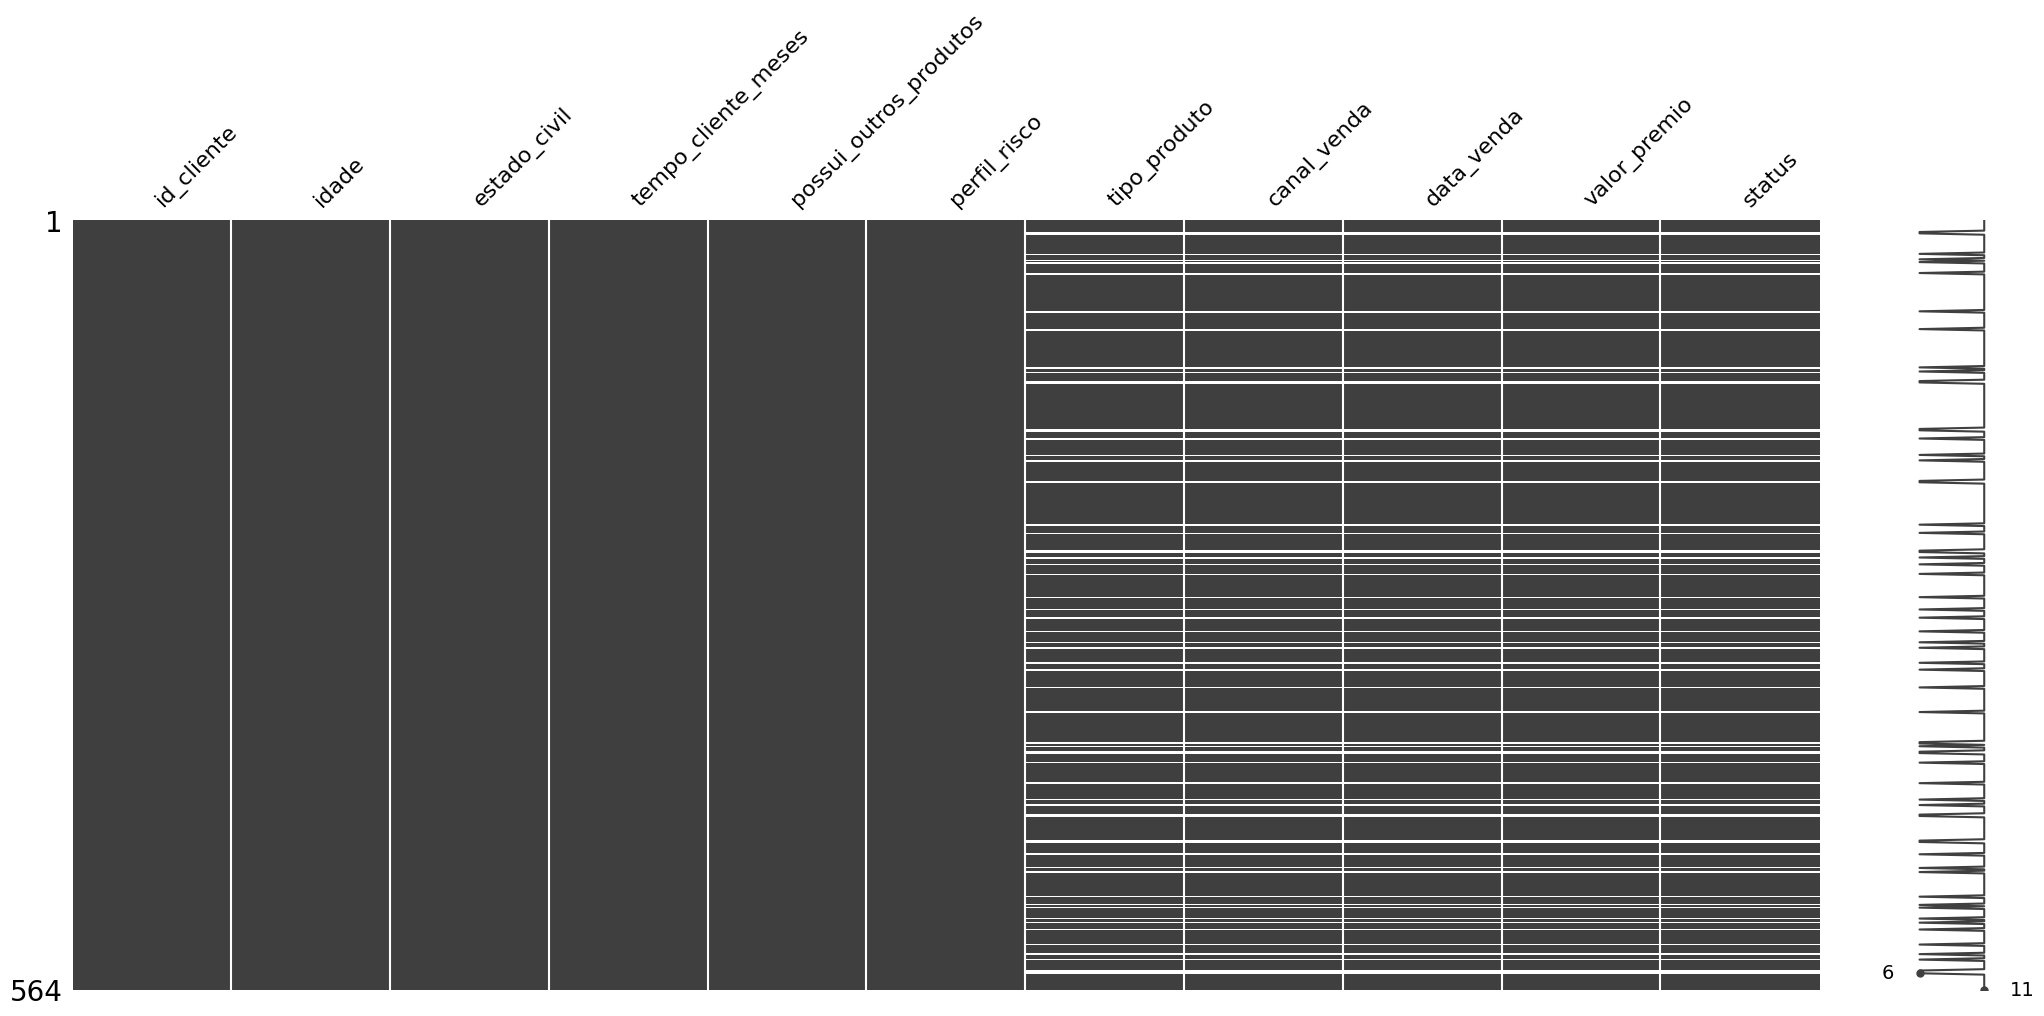

In [7]:
msno.matrix(df_merge)

In [8]:
#clientes
perfil_risco_map = {"baixo":1, "médio":2, "alto":3}
possui_outros_produtos_map = {"não":0, "sim":1}
estado_civil_map = {"solteiro":1, "casado":2, "viúvo":3, "divorciado":4}

#vendas
tipo_produto_map = {"vida": 1, "auto":2, "residencial":3, "rural":4}
canal_venda_map = {"telefone":1, "agência":2, "app":3, "parceiro":4}
status_map = {"efetivado":1, "cancelado":0}

In [9]:
df_numerico = df_merge

df_numerico["estado_civil"] = df_numerico["estado_civil"].map(estado_civil_map)
df_numerico["possui_outros_produtos"] = df_numerico["possui_outros_produtos"].map(possui_outros_produtos_map)
df_numerico["perfil_risco"] = df_numerico["perfil_risco"].map(perfil_risco_map)
df_numerico["tipo_produto"] = df_numerico["tipo_produto"].map(tipo_produto_map)
df_numerico["canal_venda"] = df_numerico["canal_venda"].map(canal_venda_map)
df_numerico["status"] = df_numerico["status"].map(status_map)

df_numerico["data_venda"] = pd.to_datetime(df_numerico["data_venda"], errors='coerce')

print(df_numerico.dtypes)

id_cliente                         int64
idade                              int64
estado_civil                       int64
tempo_cliente_meses                int64
possui_outros_produtos             int64
perfil_risco                       int64
tipo_produto                     float64
canal_venda                      float64
data_venda                datetime64[ns]
valor_premio                     float64
status                           float64
dtype: object


#Modelagem Preditiva: Classificação de Conversão de Vendas
1. Definição das Variáveis e Preparação dos Dados
* As colunas escolhidas representam o perfil socioeconômico e comportamental do cliente, além de características da venda.
* A variável-alvo (status) é binária:
  * 1 → Venda efetivada;
  * 0 → Venda cancelada.

* A base é filtrada para remover registros com valores ausentes (dropna()).

2. Separação entre Treinamento e Teste
* A base é dividida em treino (80%) e teste (20%), com stratify=y para manter a proporção da classe status.
* Garante-se reprodutibilidade com random_state=42.
3. Random Forest Classifier – Treinamento Base
* Modelo de floresta aleatória com 100 árvores e profundidade padrão.
* Ideal para classificações com dados tabulares e variáveis categóricas numéricas.
4. Avaliação de Performance e Importância das Variáveis
classification_report traz as métricas:

* Precisão, Revocação, F1-score e Suporte por classe.
* A importância das variáveis é extraída para entender quais atributos mais influenciam a decisão do modelo.
* Gráfico de barras exibe visualmente essa importância ordenada.
5. Cálculo da Curva ROC-AUC
* A métrica ROC AUC resume a capacidade discriminativa do modelo.
* Valores próximos de 1.0 indicam excelente performance; valores abaixo de 0.7 sugerem modelo fraco.
6. SHAP – Explicabilidade dos Modelos
* SHAP (SHapley Additive exPlanations) é utilizado para interpretar as decisões do modelo.

* O summary_plot exibe:
  * A importância média das variáveis.
  * A direção do impacto (positivo ou negativo).
  * A variabilidade do efeito para diferentes amostras.
  * O mesmo processo foi feito também com o modelo XGBClassifier.

In [11]:
colunas_modelo = [
    'idade', 'estado_civil', 'possui_outros_produtos',
    'perfil_risco', 'tipo_produto', 'canal_venda'
]

In [12]:
df_modelo = df_numerico[colunas_modelo + ['status']].dropna()
print(df_modelo.isnull().sum())

idade                     0
estado_civil              0
possui_outros_produtos    0
perfil_risco              0
tipo_produto              0
canal_venda               0
status                    0
dtype: int64


In [13]:
X = df_modelo[colunas_modelo]
y = df_modelo['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

| Métrica                    | O que mede                                                                                                                                    |
| -------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------- |
| **Precision** (Precisão)   | De todas as vezes que o modelo previu uma classe, quantas vezes acertou. Ex: "dos que o modelo disse que são 1, quantos realmente são 1?"     |
| **Recall** (Sensibilidade) | De todos os exemplos reais daquela classe, quantos o modelo conseguiu identificar. Ex: "dos que realmente são 1, quantos o modelo encontrou?" |
| **F1-score**               | Média harmônica entre precisão e recall. Balanceia os dois, útil quando existe desequilíbrio nas classes.                                     |
| **Support**                | Quantidade real de amostras daquela classe no conjunto de teste.                                                                              |


In [14]:
modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.42      0.21      0.28        24
         1.0       0.78      0.91      0.84        76

    accuracy                           0.74       100
   macro avg       0.60      0.56      0.56       100
weighted avg       0.70      0.74      0.71       100



In [16]:
y_proba = modelo.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
print(f"AUC: {roc_auc:.2f}")

AUC: 0.58


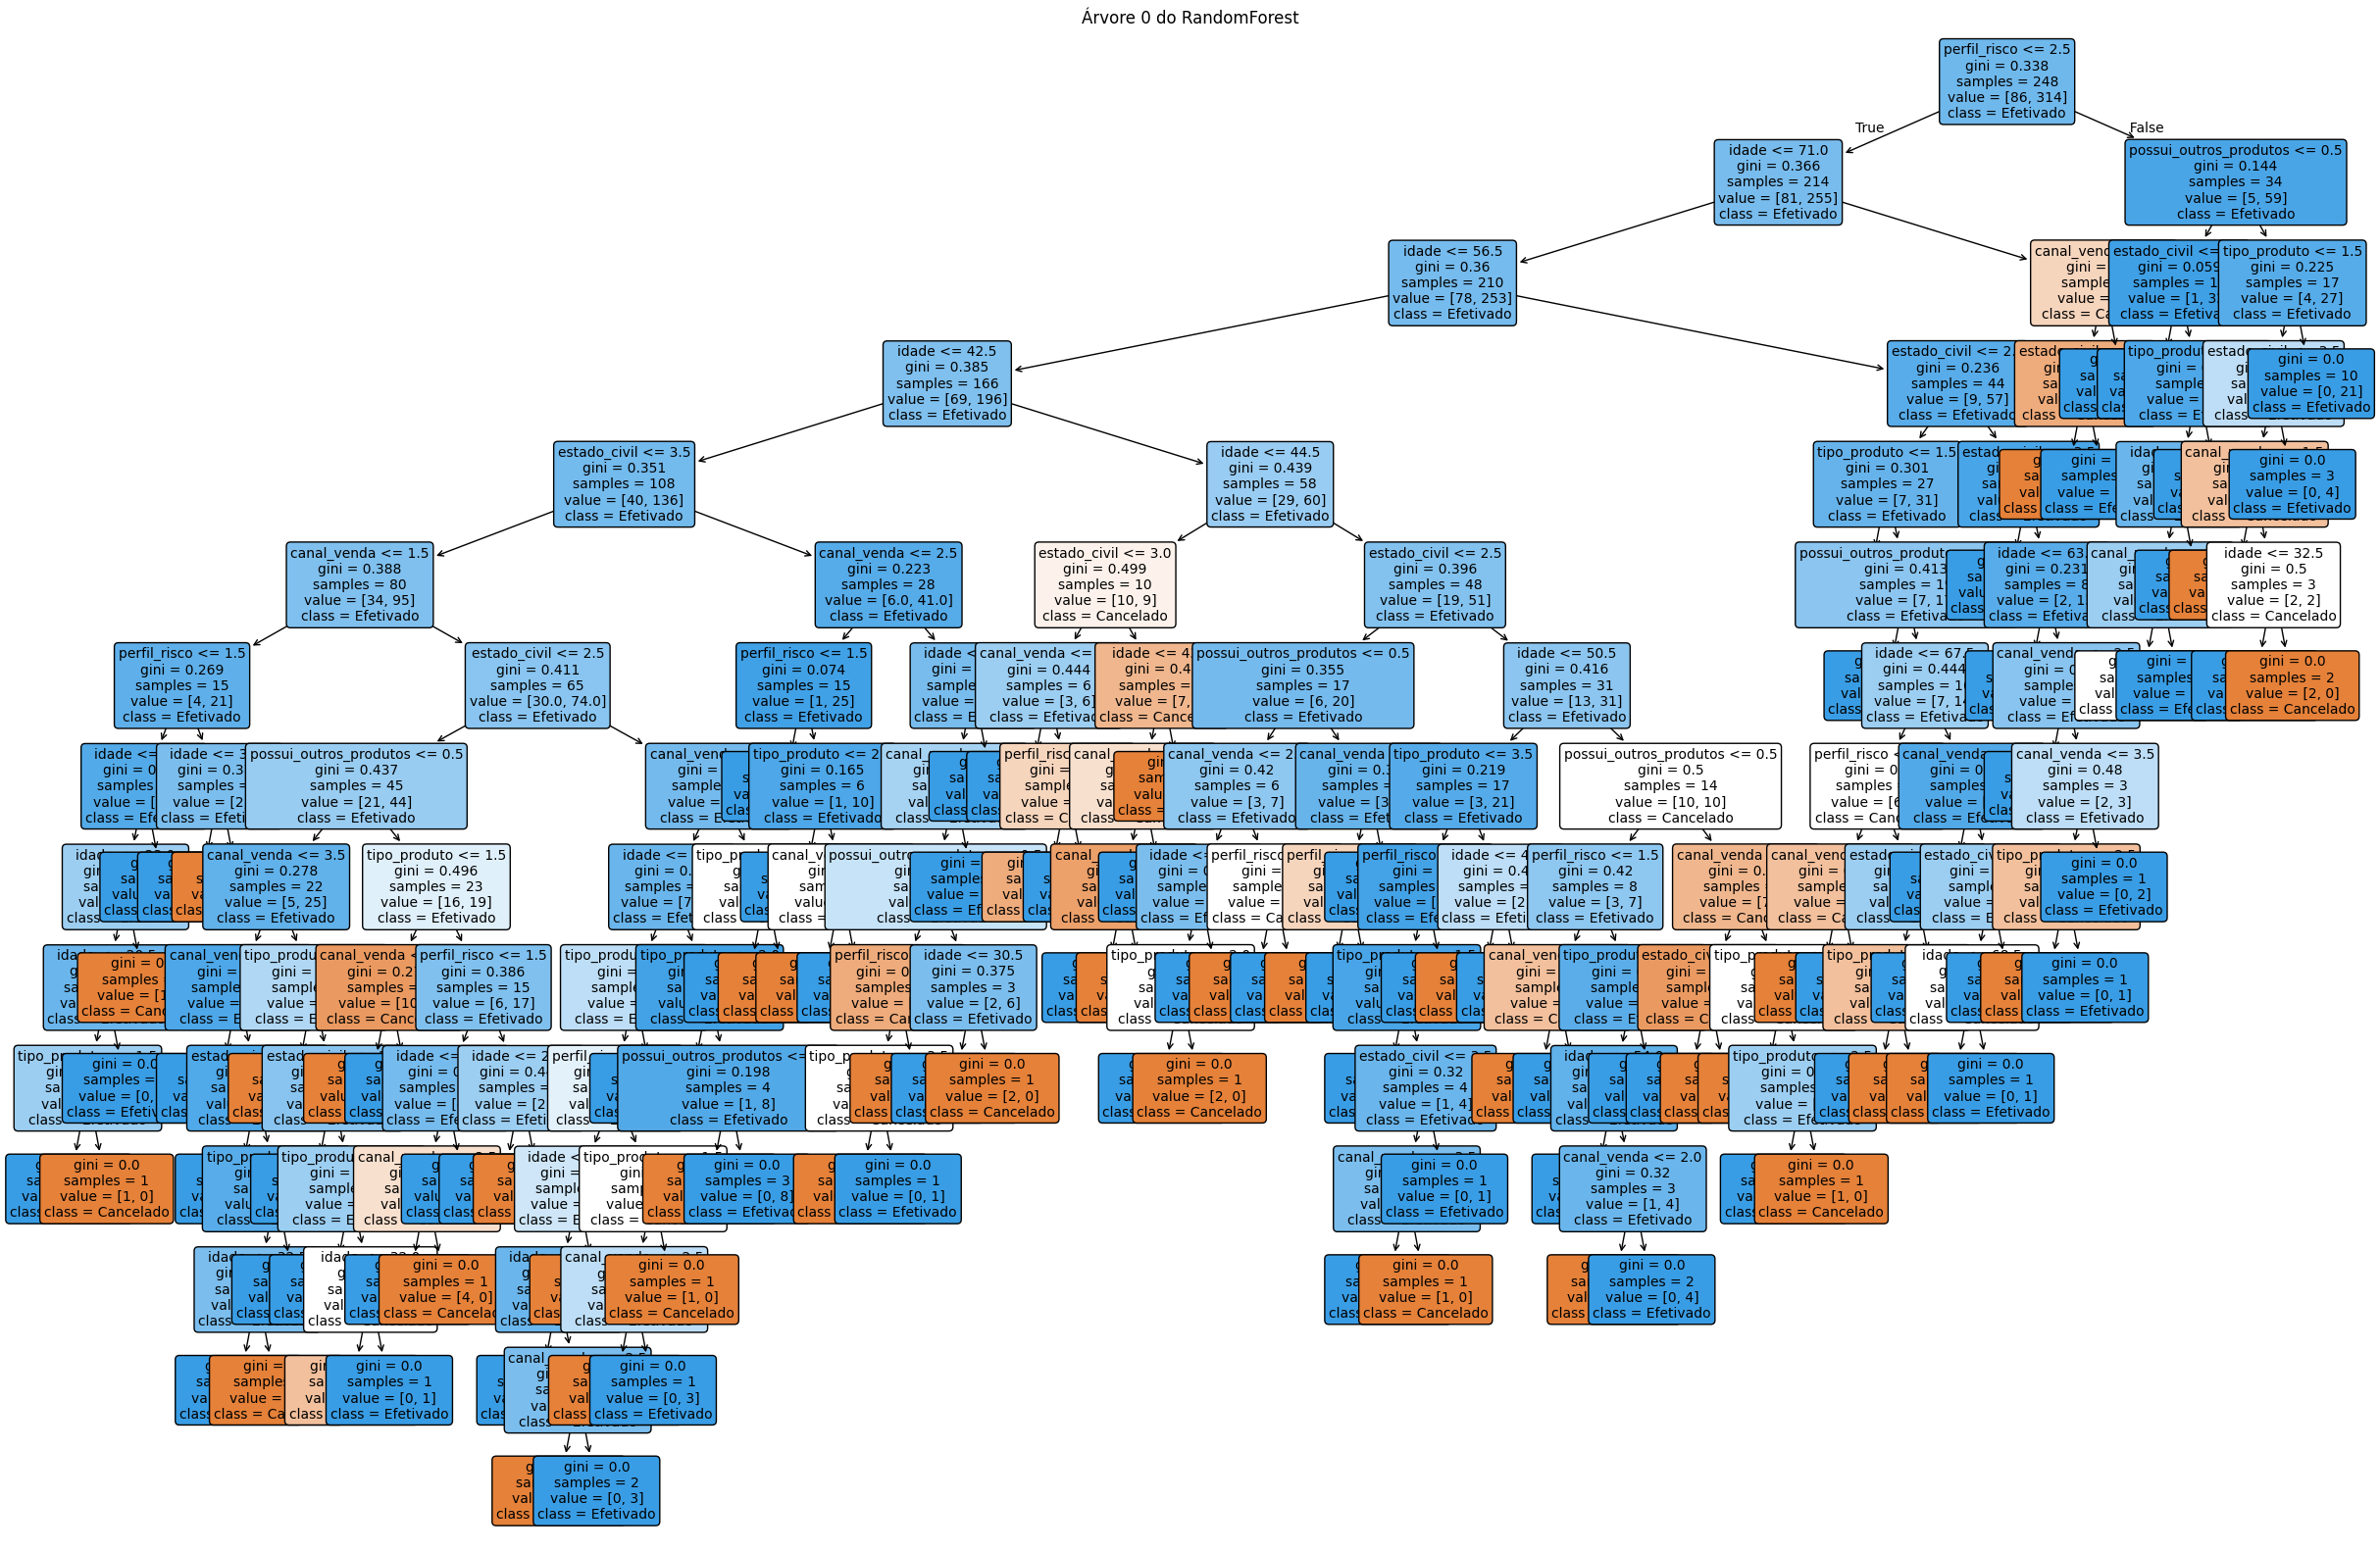

In [28]:
arvore = modelo.estimators_[0]

plt.figure(figsize=(30, 20))

plot_tree(arvore,
          feature_names=X_train.columns,
          class_names=["Cancelado", "Efetivado"],
          filled=True,
          rounded=True,
          fontsize=10)

plt.title("Árvore 0 do RandomForest")
plt.show()

In [29]:
y_proba = modelo.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

j_scores = tpr - fpr
best_index = j_scores.argmax()
best_threshold = thresholds[best_index]

print(f"Melhor threshold (Youden's J): {best_threshold:.2f}")
print(f"True Positive Rate (Recall): {tpr[best_index]:.2f}")
print(f"False Positive Rate: {fpr[best_index]:.2f}")

Melhor threshold (Youden's J): 0.97
True Positive Rate (Recall): 0.16
False Positive Rate: 0.00


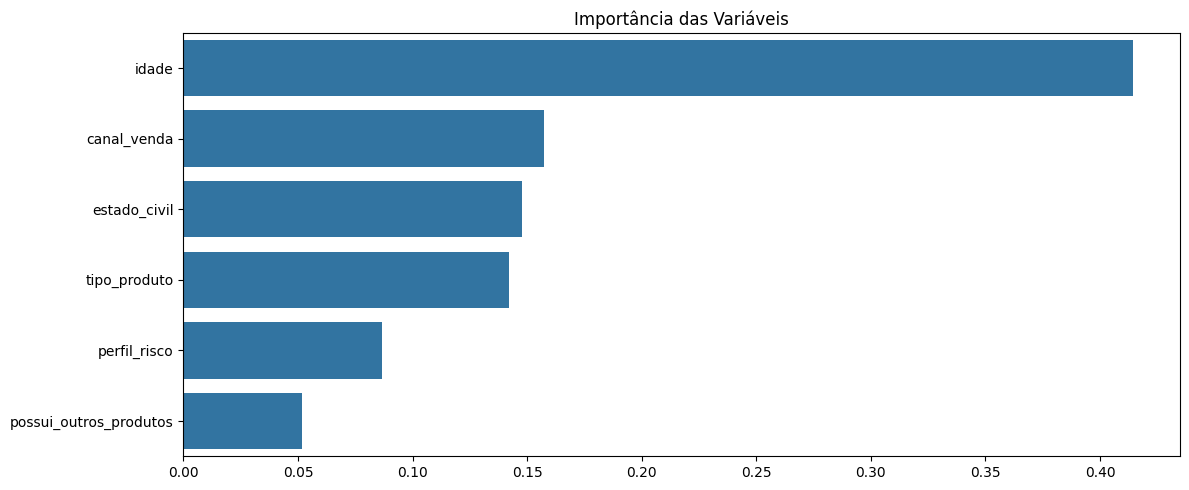

In [15]:
importances = modelo.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 5))
plt.title("Importância das Variáveis")
sns.barplot(x=importances[indices], y=[colunas_modelo[i] for i in indices])
plt.tight_layout()
plt.show()

In [36]:
features = colunas_modelo

df_efetivados = df_merge[df_merge['status'] == 1]

perfil_summary = df_efetivados[features].mode().T

perfil_summary.columns = ['Valor mais frequente']

print("Perfil típico do cliente que converte (status = 1):\n")
print(perfil_summary)

Perfil típico do cliente que converte (status = 1):

                        Valor mais frequente
idade                                   61.0
estado_civil                             3.0
possui_outros_produtos                   1.0
perfil_risco                             1.0
tipo_produto                             1.0
canal_venda                              3.0


In [34]:
perfil_risco_map_rev = {v: k for k, v in perfil_risco_map.items()}
possui_outros_produtos_map_rev = {v: k for k, v in possui_outros_produtos_map.items()}
estado_civil_map_rev = {v: k for k, v in estado_civil_map.items()}
tipo_produto_map_rev = {v: k for k, v in tipo_produto_map.items()}
canal_venda_map_rev = {v: k for k, v in canal_venda_map.items()}


In [39]:
def revert_map(value, mapping):
    return mapping.get(value, value)

perfil_summary.loc['perfil_risco', 'Valor mais frequente'] = revert_map(perfil_summary.loc['perfil_risco', 'Valor mais frequente'], perfil_risco_map_rev)
perfil_summary.loc['possui_outros_produtos', 'Valor mais frequente'] = revert_map(perfil_summary.loc['possui_outros_produtos', 'Valor mais frequente'], possui_outros_produtos_map_rev)
perfil_summary.loc['estado_civil', 'Valor mais frequente'] = revert_map(perfil_summary.loc['estado_civil', 'Valor mais frequente'], estado_civil_map_rev)
perfil_summary.loc['tipo_produto', 'Valor mais frequente'] = revert_map(perfil_summary.loc['tipo_produto', 'Valor mais frequente'], tipo_produto_map_rev)
perfil_summary.loc['canal_venda', 'Valor mais frequente'] = revert_map(perfil_summary.loc['canal_venda', 'Valor mais frequente'], canal_venda_map_rev)

print("Perfil típico do cliente que converte (status = efetivado):\n")
print(perfil_summary)

Perfil típico do cliente que converte (status = efetivado):

                       Valor mais frequente
idade                                  61.0
estado_civil                          viúvo
possui_outros_produtos                  sim
perfil_risco                          baixo
tipo_produto                           vida
canal_venda                             app
